# Developing my own security market line of expected return vs. risk(std dev) 

### Importing libraries and historical stock data
##### Using the previous 100 calendar days

In [111]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import quandl
import fredapi as fa

In [93]:
import requests
from datetime import timedelta

enddate = dt.date.today()
startdate = enddate + timedelta(days=-365)

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
html = requests.get(url).content
df_list = pd.read_html(html)
SPtable = df_list[0]
#SPtable.head()

sp500_tickers = list(SPtable["Symbol"])

## Bench Mark prices, returns and variance
spy = yf.Ticker("spy")
sp500_prices = spy.history(period="1w", start=startdate, end=enddate)
sp500_prices["returns"] = (sp500_prices["Close"] - sp500_prices["Close"].shift(1)) / sp500_prices["Close"].shift(1)
sp500_rets = sp500_prices["returns"][1:]
sp500_var = np.var(sp500_rets)
sp500_var


0.00021386367521490648

### Calculating indiviual stock to market covariances

In [94]:
sp500_covars = {}

for i in sp500_tickers:
    stock = yf.Ticker(i)
    prices = stock.history(period="1w", start=startdate, end=enddate)
    prices["returns"] = (prices["Close"] - prices["Close"].shift(1)) / prices["Close"].shift(1)
    returns = prices["returns"]
    returns = list(returns)[1:]
    covar = pd.Series(returns).cov(pd.Series(list(sp500_rets)))
    
    sp500_covars[i] = covar

sp500_covars

#Takes 3 + minutes


Got error from yahoo api for ticker BRK.B, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BRK.B: No data found for this date range, symbol may be delisted


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_36024\2081929480.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  covar = pd.Series(returns).cov(pd.Series(list(sp500_rets)))


- BF.B: No data found for this date range, symbol may be delisted


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_36024\2081929480.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  covar = pd.Series(returns).cov(pd.Series(list(sp500_rets)))


{'MMM': 0.00014204213629946804,
 'AOS': 0.00019414437529482247,
 'ABT': 0.00017128365741062542,
 'ABBV': 7.538606187919772e-05,
 'ABMD': 0.00029984860298018024,
 'ACN': 0.00024956732386601004,
 'ATVI': 4.858430446363478e-05,
 'ADM': 0.00012990019034240383,
 'ADBE': 0.00031142145104832834,
 'ADP': 0.0001983519767185087,
 'AAP': 0.00018565915294276345,
 'AES': 0.00022086657322120684,
 'AFL': 0.00015149989853139594,
 'A': 0.00023325138326800942,
 'APD': 0.00017403837230671237,
 'AKAM': 0.00016731938494835997,
 'ALK': 0.0002594161836386703,
 'ALB': 0.0003031528458589166,
 'ARE': 0.00018929614622378721,
 'ALGN': 0.0003485457213998333,
 'ALLE': 0.00020188195337861396,
 'LNT': 9.976854826568079e-05,
 'ALL': 0.00013610893312747217,
 'GOOGL': 0.00028181466020626,
 'GOOG': 0.0002795877448776651,
 'MO': 7.57063142986357e-05,
 'AMZN': 0.0003362647222239313,
 'AMCR': 0.00016983534665957828,
 'AMD': 0.00043595628655192925,
 'AEE': 9.791243152046782e-05,
 'AAL': 0.0003457105969240291,
 'AEP': 0.00010

### Calculating Betas for all Stocks

In [96]:
betas = {}

for x,y in sp500_covars.items():
    b = y/sp500_var
    betas[x] = b




### CAPM model

In [141]:
rf_rate = .041
market_rate = .08
df = pd.DataFrame([y for y in betas.values()], [x for x in betas.keys()])
df.reset_index(inplace=True)
df.rename(columns = {"index": "Ticker", 0: "Beta"}, inplace = True)


In [142]:
df["Expected Ret"] = rf_rate + df["Beta"]*(market_rate - rf_rate)
df["r/r"] = (df["Expected Ret"] - rf_rate) / df["Beta"]
df

,Ticker,Beta,Expected Ret,r/r
0,MMM,0.664171,0.066903,0.039
1,AOS,0.907795,0.076404,0.039
2,ABT,0.800901,0.072235,0.039
3,ABBV,0.352496,0.054747,0.039
4,ABMD,1.402055,0.095680,0.039
...,...,...,...,...
498,YUM,0.758548,0.070583,0.039
499,ZBRA,1.455042,0.097747,0.039
500,ZBH,0.865276,0.074746,0.039
501,ZION,1.091716,0.083577,0.039


## SML line

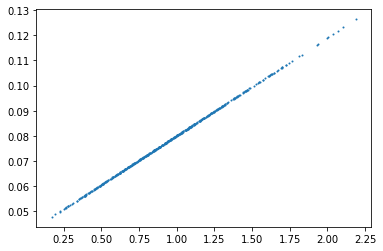

In [140]:
plt.scatter(df["Beta"], df["Expected Ret"], s=1)
plt.xlabel("Std Deviation")
plt.ylabel("Expected Return")
plt.title("Security Market Line")